## Introduction

In [the first post in this series](/blog/2019/principal_component_analysis_part_one/), we outlined the motivation and theory behind principal component analysis (PCA), which takes points $x_1, \ldots, x_N$ in a high dimensional space to points in a lower dimensional space while preserving as much of the original variance as possible.

In this follow-up post, we apply principal components regression (PCR), an algorithm which includes PCA as a subroutine, to a small dataset to demonstrate the ideas in practice.

## Prerequisites

To understand this post, you will need to be familiar with the following concepts:

* PCA (see [the first post in this series](/blog/2019/principal_component_analysis_part_one/))
* [ordinary least squares](https://en.wikipedia.org/wiki/Ordinary_least_squares)

## Ordinary least squares

In ordinary least squares (OLS), we want to find a line of best fit between the points $x_1, \ldots, x_N$ and the labels $y_1, \ldots, y_N$.

Denoting by $X$ the matrix whose rows are the points and $y$ the vector whose entries are the labels, the intercept $\alpha$ and slope (a.k.a. gradient) $\beta$ are obtained by minimizing $\Vert \alpha + X \beta - y \Vert$.
Some [matrix calculus](https://en.wikipedia.org/wiki/Matrix_calculus) reveals that the minimum is obtained at the values of $\alpha$ and $\beta$ for which
\begin{equation}
    N \alpha = y^\intercal e - \beta^\intercal X^\intercal e
\end{equation}
and
\begin{equation}
    X^\intercal X \beta = X^\intercal y - \alpha X^\intercal e
\end{equation}
where $e$ is the vector of all ones.

## Principal components regression

The idea behind PCR is simple: instead of doing OLS on the high dimensional space, we first map the points to a lower dimensional space obtained by PCA and *then* do OLS.
In more detail, we

1. pick a positive integer $k < p$,
2. construct the matrix $V_k$ whose columns are the first $k$ principal components of $X$,
3. compute $Z_k = X V_k$, a matrix whose rows are the original points transformed to a lower dimensional "PCA space", and
4. perform OLS to find a line of best fit between the transformed points and $y$.

By the previous section, we know that the minimum is obtained at the values of the intercept $\alpha_k$ and gradient $\beta_k$ for which
\begin{equation}
    N \alpha_k = y^\intercal e - \beta_k^\intercal Z_k^\intercal e
\end{equation}
and
\begin{equation}
    Z_k^\intercal Z_k \beta_k = Z_k^\intercal y - \alpha_k Z_k^\intercal e
\end{equation}

Once we have solved these equations for $\alpha_k$ and $\beta_k$, we can predict the label $\hat{y}$ corresponding to a new sample $x$ as $\hat{y} = \alpha_k + x^\intercal V_k \beta_k$.

### Computational considerations

Due to the result below, the linear system involving $\alpha_k$ and $\beta_k$ is a (permuted) [arrowhead matrix](https://en.wikipedia.org/wiki/Arrowhead_matrix).
As such, the system can be solved efficiently.

**Lemma.** $Z_k^\intercal Z_k = \Sigma_k^2$ where $\Sigma_k$ is the $k \times k$ diagonal matrix whose entries are the first $k$ principal components of $X$ in descending order.

*Proof*.
Let $v_j$ denote the $j$-th column of $V_k$.
Since $v_j$ is a principal component of $X$, it is also an eigenvector of $X^\intercal X$ with eigenvalue $\sigma_j^2$, the square of the $j$-th singular value.
Therefore, the $(i, j)$-th entry of $Z_k^\intercal Z_k$ is
\begin{equation}
    (X v_i)^\intercal (X v_j)
    = v_i^\intercal X^\intercal X v_j
    = \sigma_j^2 v_i^\intercal v_j
    = \sigma_j^2 \delta_{ij}.
\end{equation}
where $\delta_{ij}$ is the [Kronecker delta](https://en.wikipedia.org/wiki/Kronecker_delta).

## The California housing dataset

The [California housing dataset](https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html) from \[1\] has 20,640 samples and 8 predictors.
For each $k \leq p = 8$, we fit using PCR on 80% of the samples (the training set) and report the [root mean squared error](https://en.wikipedia.org/wiki/Root-mean-square_deviation) (RMSE) on both the training set and the  remaining 20% samples (the test set).

In [24]:
%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [195]:
from sklearn.datasets import fetch_california_housing
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
import numpy as np


np.random.seed(1)
X_all, y_all = fetch_california_housing(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2)


def fit(degree: int = 1):
    """Fits a PCR model to the training data.

    Parameters
    ----------
    degree: Generates all polynomial combinations of the features up to the specified degree.

    Returns
    -------
    An `sklearn.pipeline.Pipeline` object corresponding to a learned model.
    """
    pipeline = make_pipeline(
        StandardScaler(),
        PolynomialFeatures(degree, include_bias=False),
        PCA(),
        LinearRegression(),
    )
    pipeline.fit(X_train, y_train)
    return pipeline


def rmses(model, X, y):
    """Calculates the RMSE of the model using only the first k PCs for each possible value of k.

    Parameters
    ----------
    model: The `sklearn.pipeline.Pipeline` object returned by the `fit` method.
    X: An (N, p) matrix of features.
    y: The corresponding (N) vector of targets.

    Returns
    -------
    A list of RMSEs (the first entry corresponds to k=1 and the last to k=p).
    """
    pca = model[:-1]
    Z = pca.transform(X)
    regression = model[-1]
    results = []
    for k in range(1, Z.shape[1] + 1):
        pred = regression.intercept_ + Z[:, :k] @ regression.coef_[:k]
        rmse = mean_squared_error(y, pred, squared=False)
        results.append(rmse)
    return results


model = fit()
rmses_train = rmses(model, X_train, y_train)
rmses_test = rmses(model, X_test, y_test)

In [196]:
from tabulate import tabulate


ranks = range(1, X.shape[1] + 1)
rows = zip(ranks, rmses_train, rmses_test)
tabulate(
    rows,
    headers=[
        "Rank (k)",
        "Training set RMSE (in $100,000s)",
        "Test set RMSE (in $100,000s)",
    ],
    tablefmt="html",
)

'<table>\n<thead>\n<tr><th style="text-align: right;">  Rank (k)</th><th style="text-align: right;">  Training set RMSE (in $100,000s)</th><th style="text-align: right;">  Test set RMSE (in $100,000s)</th></tr>\n</thead>\n<tbody>\n<tr><td style="text-align: right;">         1</td><td style="text-align: right;">                          1.15492 </td><td style="text-align: right;">                      1.14608 </td></tr>\n<tr><td style="text-align: right;">         2</td><td style="text-align: right;">                          1.14128 </td><td style="text-align: right;">                      1.12491 </td></tr>\n<tr><td style="text-align: right;">         3</td><td style="text-align: right;">                          1.13947 </td><td style="text-align: right;">                      1.12457 </td></tr>\n<tr><td style="text-align: right;">         4</td><td style="text-align: right;">                          0.853976</td><td style="text-align: right;">                      0.844071</td></tr>\n<tr><td style="text-align: right;">         5</td><td style="text-align: right;">                          0.853972</td><td style="text-align: right;">                      0.844123</td></tr>\n<tr><td style="text-align: right;">         6</td><td style="text-align: right;">                          0.810381</td><td style="text-align: right;">                      0.807466</td></tr>\n<tr><td style="text-align: right;">         7</td><td style="text-align: right;">                          0.729905</td><td style="text-align: right;">                      0.731179</td></tr>\n<tr><td style="text-align: right;">         8</td><td style="text-align: right;">                          0.723369</td><td style="text-align: right;">                      0.72742 </td></tr>\n</tbody>\n</table>'

Both training and test set RMSEs are (roughly) decreasing functions of the rank.
This suggests that using all 8 predictors does not cause overfitting.

### Deriving predictors

One way to reduce the test set RMSE is to introduce more predictors into the model.
Consider, as a toy example, a dataset where each sample $x_i$ has only three predictors: $x_i \equiv (a_i, b_i, c_i)$.
We can replace each sample $x_i$ by a new sample $x_i^\prime \equiv (a_i, b_i, c_i, a_i^2, a_i b_i, a_i c_i, b_i^2, b_i c_i, c_i^2)$.
In particular, we have added all possible quadratic monomials in $a_i, b_i, c_i$.
These new entries are referred to as "derived" predictors.
Note that derived predictors need not be quadratic, or even monomials; any function of the original predictors is referred to as a derived predictor.

Returning to the dataset, we add all cubic monomials.
It is reasonable to expect that unlike OLS applied to $X$, OLS applied to the derived matrix $X^\prime$ will almost certainly overfit.
We plot the results (obtained by setting `degree=3` in the previous fitting code) of PCR below, observing the effects of overfitting at large values of the rank.

In [185]:
model = fit(degree=3)
rmses_train = rmses(model, X_train, y_train)
rmses_test = rmses(model, X_test, y_test)

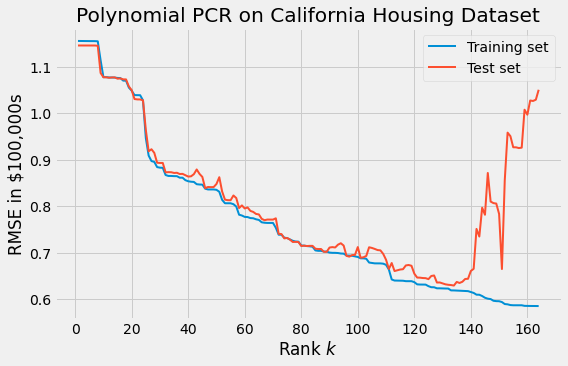

In [186]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use("fivethirtyeight")
mpl.rcParams["lines.linewidth"] = 2
plt.figure(figsize=(1.618 * 5.0, 5.0))
results = np.array(rows)
plt.plot(range(1, len(rmses_train) + 1), rmses_train, label="Training set")
plt.plot(range(1, len(rmses_test) + 1), rmses_test, label="Test set")
plt.legend()
plt.ylabel("RMSE in \$100,000s")
plt.xlabel("Rank $k$")
_ = plt.title("Polynomial PCR on California Housing Dataset")

## Bibliography

\[1\] Pace, R. Kelley, and Ronald Barry. "Sparse spatial autoregressions." Statistics & Probability Letters 33.3 (1997): 291-297.

In [ ]:
"""
Old version
"""

np.random.seed(1)

X, y = fetch_california_housing(return_X_y=True)
p = X.shape[1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Normalize data.
X_mean = np.mean(X_train, axis=0)
X_std = np.std(X_train, axis=0)
X_test, X_train = [(X_sub - X_mean) / X_std for X_sub in [X_test, X_train]]

_, _, V_T = np.linalg.svd(X_train)
V = V_T.T

rows = []
for k in range(1, p + 1):
    V_k = V[:, :k]
    Z_k = X_train @ V_k

    # Solve for alpha_k and beta_k by adding a bias column to Z_k.
    # This is not efficient (see "Computational considerations" above).
    Z_k_bias = np.concatenate([np.ones([y_train.size, 1]), Z_k], axis=1)
    solution = np.linalg.solve(Z_k_bias.T @ Z_k_bias, Z_k_bias.T @ y_train)
    alpha_k = solution[0]
    beta_k = solution[1:]

    V_k_beta_k = V_k @ beta_k

    row = [k]
    for X_sub, y_sub in [(X_train, y_train), (X_test, y_test)]:
        y_hat = alpha_k + X_sub @ V_k_beta_k
        error = y_hat - y_sub
        rmse = np.sqrt(np.mean(error**2))
        row.append(rmse)
    rows.append(row)
    
tabulate(
    rows[:8],
    headers=[
        "Rank (k)",
        "Training set RMSE (in $100,000s)",
        "Test set RMSE (in $100,000s)",
    ],
    tablefmt="html",
)